# Background of Uplift Model
- Uplift modelling, also known as incremental modelling, true lift modelling, or net modelling is a predictive modelling technique that directly models the incremental impact of a treatment (such as a direct marketing action) on an individual's behaviour.
- there is a fundamental segmentation that separates customers into the following groups:
  - The Persuadables : customers who only respond to the marketing action because they were targeted
  - The Sure Things  : customers who would have responded whether they were targeted or not
  - The Lost Causes  : customers who will not respond irrespective of whether or not they are targeted
  - The Do Not Disturbs or Sleeping Dogs : customers who are less likely to respond because they were targeted
- The Evaluation index
- 增益值柱状图 increment value histogram
- Qini 曲线 AUUC(AREA UNDER UPLIFT CURVE)
- 累积增益曲线 Accumulated increment curve


In [2]:
import pandas as pd # data processing, like pd.read_csv()
import numpy as np # linear algebra
import warnings# to make all the coding result more readable, ignnore the warning information
warnings.filterwarnings('ignore')
#import matplot and seaborn to draw the figures
import matplotlib.pyplot as plt
import seaborn as sns

# Data Exploration

In [3]:
from pathlib import Path
df=pd.read_csv(Path('data.csv'))# use .read_csv() method to get the whole data

In [4]:
df.head(5)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   offer          64000 non-null  object 
 8   conversion     64000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB


1. Explanation of important index
two marketing events
- used_discount
- used_bogo
- offer: whether marketing reach customers
- conversion: whether user convert into buying
2. Missing Value
After checking the basic information of the dataset, there is no missing value in the dataset.
3. Categorical Value
- zip_code
- channel
- offer

In [6]:
df.describe(include='object').T

,count,unique,top,freq
zip_code,64000,3,Surburban,28776
channel,64000,3,Web,28217
offer,64000,3,Buy One Get One,21387


In [7]:
# check the unique object data
for col in df.columns:
    if df[col].dtype=='object':
        print()
        print(col)
        print(df[col].value_counts())


zip_code
Surburban    28776
Urban        25661
Rural         9563
Name: zip_code, dtype: int64

channel
Web             28217
Phone           28021
Multichannel     7762
Name: channel, dtype: int64

offer
Buy One Get One    21387
Discount           21307
No Offer           21306
Name: offer, dtype: int64


In [8]:
for column in df.columns:
  print(column,'-',df[column].unique())

recency - [10  6  7  9  2  1  5  4  3 11 12  8]
history - [142.44 329.08 180.65 ... 519.69 105.54 552.94]
used_discount - [1 0]
used_bogo - [0 1]
zip_code - ['Surburban' 'Rural' 'Urban']
is_referral - [0 1]
channel - ['Phone' 'Web' 'Multichannel']
offer - ['Buy One Get One' 'No Offer' 'Discount']
conversion - [0 1]


# Data Preprocessing

In [9]:
#rename the target column
df_model=df.rename(columns={'conversion':'target'})
df_model=df_model.rename(columns={'offer':'treatment'})
df_model.treatment=df_model.treatment.map({'No Offer':0,'Buy One Get One':-1,'Discount':1})

In [10]:
#One-Hot Encoding
df_model=pd.get_dummies(df_model)

<Axes: >

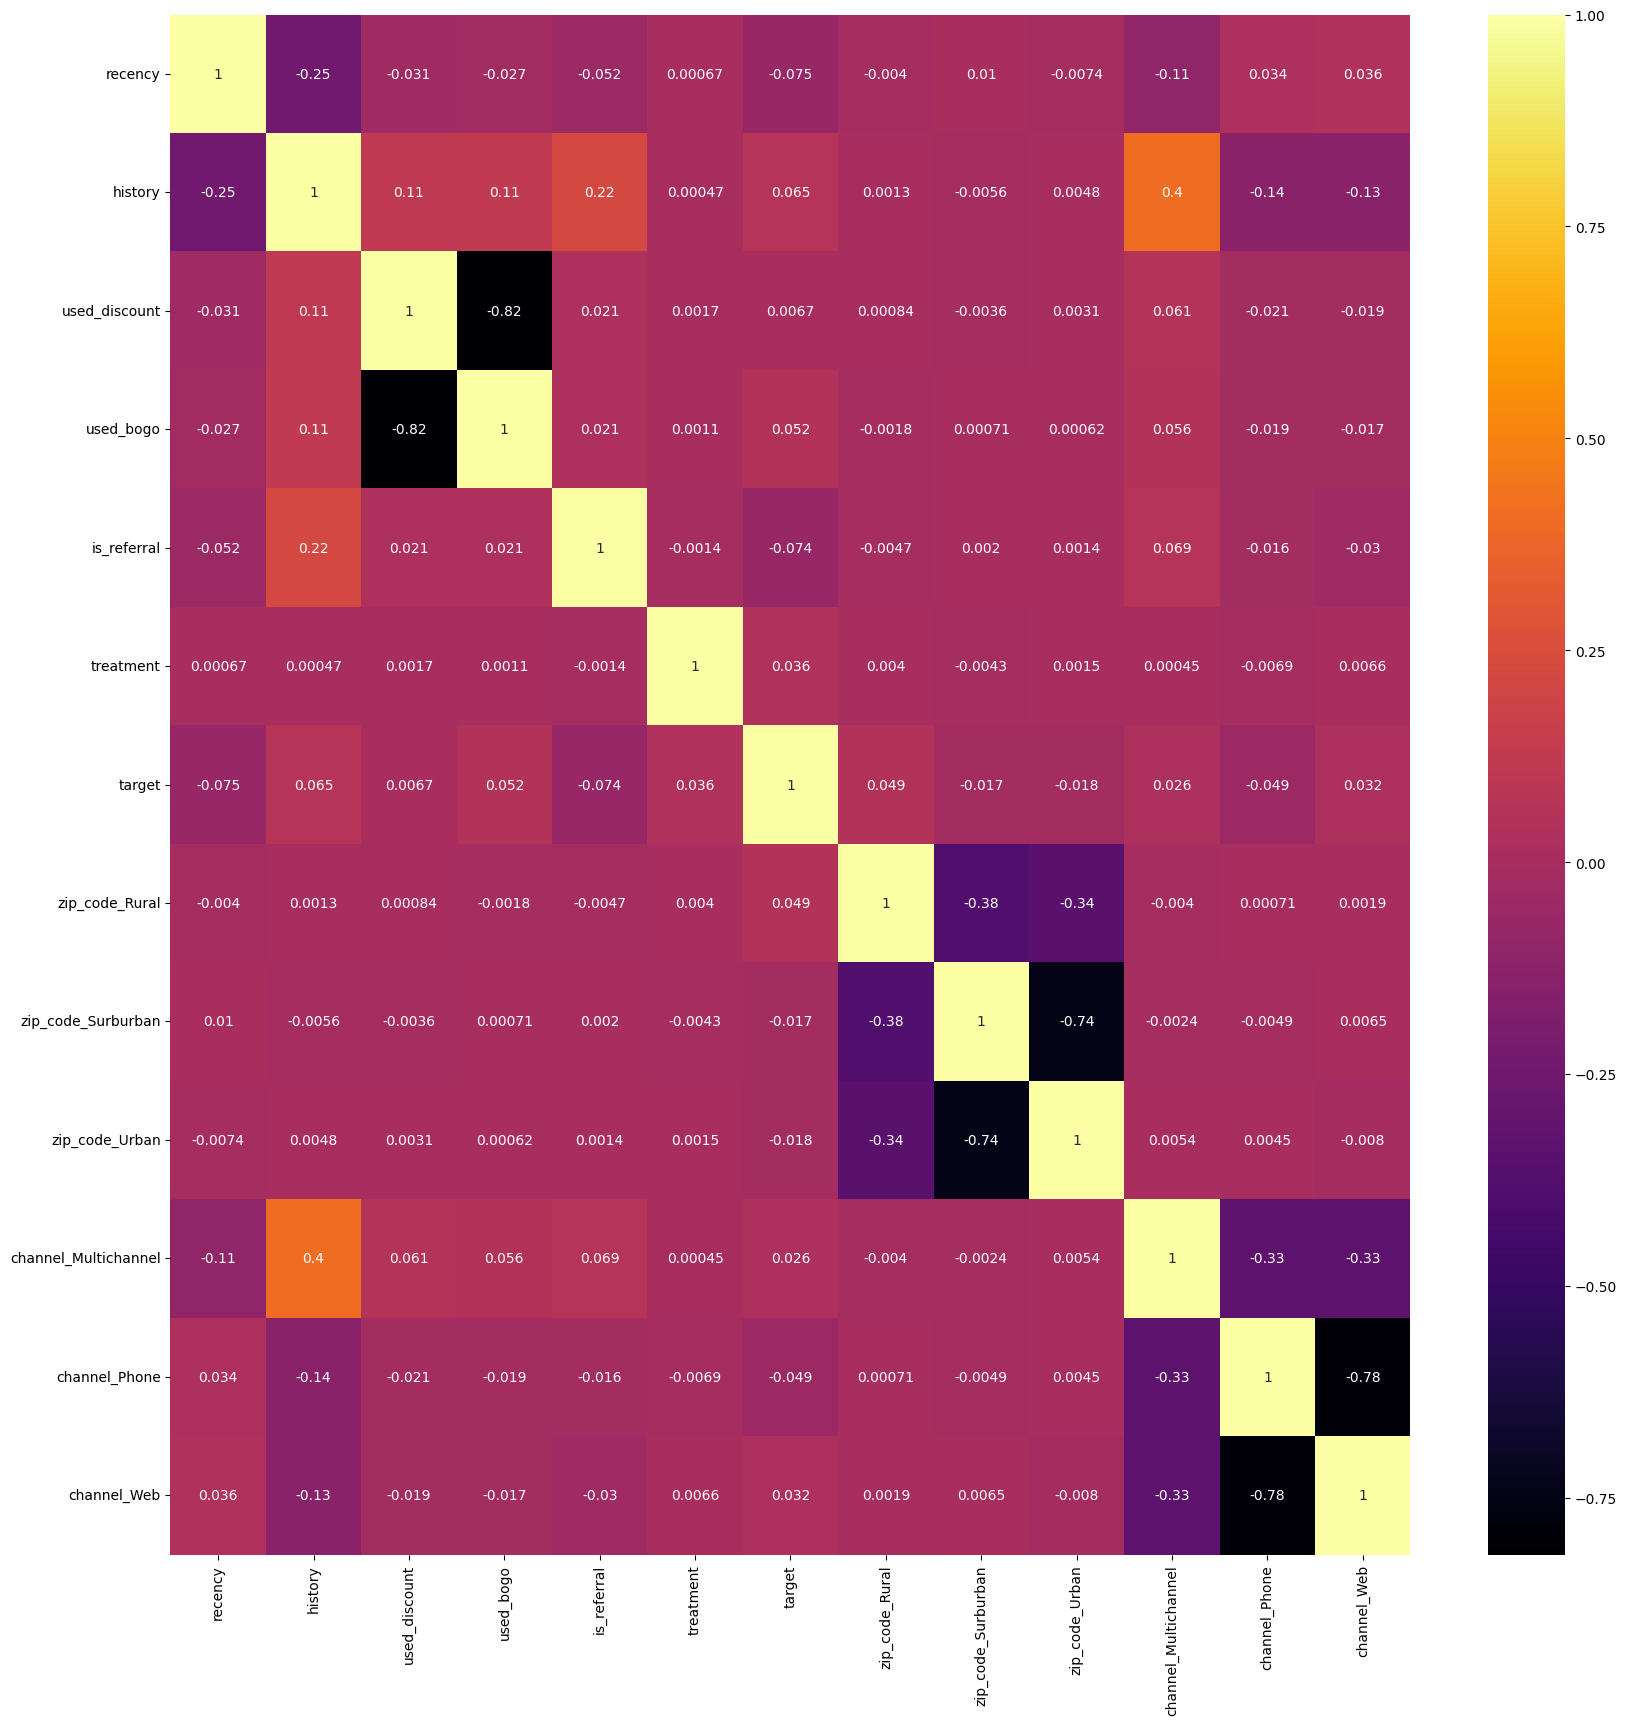

In [11]:
#Explotary Data Analysis
fig_dims = (20, 20)
fig, ax = plt.subplots(figsize=fig_dims)#define a specified size of 20x20
sns.heatmap(df_model.corr(method='pearson'), annot=True, cmap='inferno')
#use the sns.heatmap method, with the correlation matrix as the input data, annot=True to display the correlation values on the heatmap, and the cmap parameter set to 'inferno' to specify the color scheme.

- there is no column has strong relationship with the target

In [12]:
# Uplift Model is based on the premise of sample balance between treatments, check the sample balance before using model
plt.figure(figsize=(10,6))
target_count=df_model['treatment'].value_counts()
print('Class 0:',target_count[0])
print('Class 1:',target_count[1])
print('Class -1:',target_count[-1])


Class 0: 21306
Class 1: 21307
Class -1: 21387


<Figure size 1000x600 with 0 Axes>

The Distribution is balanced, there is no need to take oversampling method

# Model Building

#Target Class Declaration
- CN: Control Non-Responders:Customer that don't make a purchase without an offer
- CR：Control Responders:Customers that make a purchase without an offer
- TN: Treatment Non-Responders:Customer that don't make a purchase and receive an offer
- TR: Treatment Responders:Customers that make a purchase and receive an offer

In [13]:
# Add target_class
df_model['target_class'] = 0
df_model.loc[(df_model.treatment==0)&(df_model.target!=0),'target_class']=1
df_model.loc[(df_model.treatment!=0)&(df_model.target==0),'target_class']=2
df_model.loc[(df_model.treatment!=0)&(df_model.target!=0),'target_class']=3

In [14]:
# Train and test split
from sklearn.model_selection import train_test_split
X=df_model.drop(['target','target_class'],axis=1)
y=df_model.target_class
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42,stratify=df_model['treatment'])

Uplift Score
LGWUM: P-Probability Score, T-Total treated population(TR+TN),C-total untreated population(CR+CN)
Uplift Score=P(TR)/P(T)+P(CN)/P(C)-P(TN)/P(T)-P(CR)/P(C)



In [15]:
import xgboost as xgb
#Using XGB to get the uplift score
# Create new dataframe
result = pd.DataFrame(X_test).copy()
# Fit the model
uplift_model= xgb.XGBClassifier().fit(X_train.drop('treatment', axis=1), y_train)
# Predict using test-data
uplift_proba= uplift_model.predict_proba(X_test.drop('treatment', axis=1))
result['proba_CN'] = uplift_proba[:,0]
result['proba_CR'] = uplift_proba[:,1]
result['proba_TN'] = uplift_proba[:,2]
result['proba_TR'] = uplift_proba[:,3]
result['uplift_score'] = result.eval('proba_CN/(proba_CN+proba_CR)+proba_TR/(proba_TN+proba_TR)- proba_TN/(proba_TN+proba_TR)- proba_CR/(proba_CN+proba_CR)')
# Put the result
result['target_class'] = y_test

In [16]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12800 entries, 50498 to 21156
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   recency               12800 non-null  int64  
 1   history               12800 non-null  float64
 2   used_discount         12800 non-null  int64  
 3   used_bogo             12800 non-null  int64  
 4   is_referral           12800 non-null  int64  
 5   treatment             12800 non-null  int64  
 6   zip_code_Rural        12800 non-null  uint8  
 7   zip_code_Surburban    12800 non-null  uint8  
 8   zip_code_Urban        12800 non-null  uint8  
 9   channel_Multichannel  12800 non-null  uint8  
 10  channel_Phone         12800 non-null  uint8  
 11  channel_Web           12800 non-null  uint8  
 12  proba_CN              12800 non-null  float32
 13  proba_CR              12800 non-null  float32
 14  proba_TN              12800 non-null  float32
 15  proba_TR       

In [17]:
# Run the uplift function
bogo_uplift = result.copy().loc[result.treatment<=0].reset_index(drop=True)
discount_uplift = result.copy().loc[result.treatment>=0].reset_index(drop=True)

# Evaluation

In [18]:
# Functions to build the Uplift model and visualize the QINI Curve
def qini_rank(uplift:pd.DataFrame):
    """Rank the data by the uplift score
    """
    # Creat new dataframe
    ranked = pd.DataFrame({'n':[], 'target_class':[]})
    ranked['target_class'] = uplift['target_class']
    ranked['uplift_score'] = uplift['uplift_score']


    # Add proportion
    ranked['n'] = ranked.uplift_score.rank(pct=True, ascending=False)
    # Data Ranking
    ranked = ranked.sort_values(by='n').reset_index(drop=True)
    return ranked


def qini_eval(ranked:pd.DataFrame):
    """Evaluate the uplift value with the QINI criterion
    """
    uplift_model, random_model = ranked.copy(), ranked.copy()
    # Using Treatment and Control Group to calculate the uplift (Incremental gain)
    C, T = sum(ranked['target_class'] <= 1), sum(ranked['target_class'] >= 2)
    ranked['cr'] = 0
    ranked['tr'] = 0
    ranked.loc[ranked.target_class == 1,'cr'] = 1
    ranked.loc[ranked.target_class == 3,'tr'] = 1
    ranked['cr/c'] = ranked.cr.cumsum() / C
    ranked['tr/t'] = ranked.tr.cumsum() / T
    # Calculate and put the uplift and random value into dataframe
    uplift_model['uplift'] = round(ranked['tr/t'] - ranked['cr/c'],5)
    random_model['uplift'] = round(ranked['n'] * uplift_model['uplift'].iloc[-1],5)


    # Add q0
    q0 = pd.DataFrame({'n':0, 'uplift':0, 'target_class': None}, index =[0])
    uplift_model = pd.concat([q0, uplift_model]).reset_index(drop = True)
    random_model = pd.concat([q0, random_model]).reset_index(drop = True)
    # Add model name & concat
    uplift_model['model'] = 'Uplift model'
    random_model['model'] = 'Random model'
    merged = pd.concat([uplift_model, random_model]).sort_values(by='n').reset_index(drop = True)
    return merged


def qini_plot(merged:pd.DataFrame):
    """Plot the QINI
    """
    # plot the data
    ax = sns.lineplot(x='n', y='uplift', hue='model', data=merged,
                      style='model', palette=['red','grey'])


    # Plot settings
    sns.set_style('whitegrid')
    handles, labels = ax.get_legend_handles_labels()
    plt.xlabel('Proportion targeted',fontsize=15)
    plt.ylabel('Uplift',fontsize=15)
    plt.subplots_adjust(right=1)
    plt.subplots_adjust(top=1)
    plt.legend(fontsize=12)
    ax.tick_params(labelsize=15)
    ax.legend(handles=handles[1:], labels=labels[1:], loc='upper right')
    return ax


def qini(uplift:pd.DataFrame):
    """Combine all functions
    """
    ranked = qini_rank(uplift)
    merged = qini_eval(ranked)
    ax = qini_plot(merged)
    return ax

# Result

Text(0.5, 1.0, 'Qini Curve - Buy One Get One')

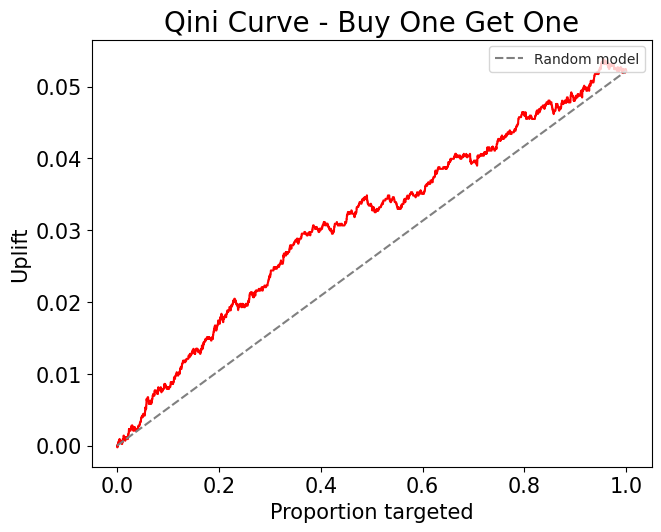

In [19]:
# plot the Qini curve for BOGO treatment
qini(bogo_uplift)
plt.title('Qini Curve - Buy One Get One',fontsize=20)

Text(0.5, 1.0, 'Qini Curve - Discount')

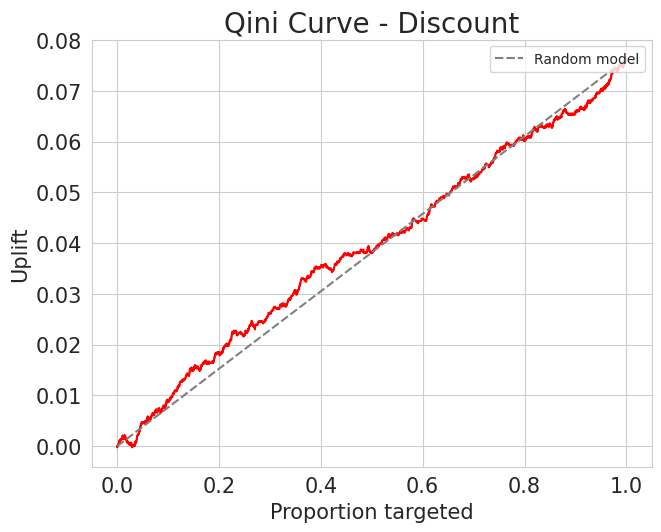

In [20]:
# plot the Qini curve for Discount treatment
qini(discount_uplift)
plt.title('Qini Curve - Discount',fontsize=20)